In [299]:
%matplotlib inline

import warnings
import os
from pathlib import Path
import quandl
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import seaborn as sns
import graphviz
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, _tree
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, KFold
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve
from sklearn.preprocessing import Imputer
import statsmodels.api as sm
from scipy.interpolate import interp1d, interp2d

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## Get Data

In [3]:
with pd.HDFStore('../data/assets.h5') as store:
    print(store.info())
    prices = store['quandl/wiki/prices'].adj_close.unstack('ticker')
    stocks = store['us_equities/stocks']

<class 'pandas.io.pytables.HDFStore'>
File path: ../data/assets.h5
/fred/assets                   frame        (shape->[4826,5])     
/quandl/wiki/prices            frame        (shape->[15389314,12])
/quandl/wiki/stocks            frame        (shape->[1,2])        
/sp500/prices                  frame        (shape->[37721,5])    
/sp500/stocks                  frame        (shape->[1,7])        
/us_equities/stocks            frame        (shape->[1,6])        


In [4]:
shared = prices.columns.intersection(stocks.index)
prices = prices.loc['2010': '2018', shared]
stocks = stocks.loc[shared, ['marketcap', 'ipoyear', 'sector']]

In [ ]:
prices.info()

### Create monthly returns

Remove outliers

In [ ]:
returns = prices.resample('M').pct_change().stack().swaplevel()
returns = returns[returns.between(left=returns.quantile(.05), right=returns.quantile(.95))].to_frame('returns')

In [ ]:
for t in range(1, 13):
    returns[f't-{t}'] = returns.groupby(level='ticker').returns.shift(t)
returns = returns.dropna()

In [ ]:
dates = returns.index.get_level_values('date')
returns['year'] = dates.year
returns['month'] = dates.month
returns = pd.get_dummies(returns, columns=['year', 'month'])
returns = returns.reset_index('date', drop=True)

In [ ]:
returns.info()

In [ ]:
stocks.info()
stocks.ipoyear = pd.qcut(stocks.ipoyear, q=5, labels=list(range(1, 6)))

In [ ]:
stocks.marketcap = stocks.marketcap.str.replace('$', '')
stocks['mcap'] = stocks.marketcap.str[-1]
stocks.marketcap =  pd.to_numeric(stocks.marketcap.str[:-1])
stocks = stocks[stocks.mcap.isin(['B', 'M'])]
stocks.info()

In [ ]:
stocks.marketcap = stocks.apply(lambda x: x.marketcap * 1000 if x.mcap == 'B' else x.marketcap, axis=1)
stocks.marketcap = pd.qcut(stocks.marketcap, q=10, labels=list(range(1, 11)))
stocks = stocks.drop('mcap', axis=1)

In [ ]:
stocks = pd.get_dummies(stocks, prefix=['size', 'age', ''], prefix_sep=['_', '_', ''])
stocks.info()

In [ ]:
data = returns.join(stocks).dropna()
s = len(returns.columns)
data.iloc[:, s:] = data.iloc[:, s:].astype(int).apply(pd.to_numeric, downcast='integer')
data.info()

In [ ]:
with pd.HDFStore('data.h5') as store:
    store.put('data', data)

In [3]:
with pd.HDFStore('data.h5') as store:
    data = store['data']
    data = data.drop([f't-{t}' for t in range(7, 13)] + [c for c in data.columns if c.startswith('month')], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174551 entries, A to ZUMZ
Data columns (total 43 columns):
returns                  174551 non-null float64
t-1                      174551 non-null float64
t-2                      174551 non-null float64
t-3                      174551 non-null float64
t-4                      174551 non-null float64
t-5                      174551 non-null float64
t-6                      174551 non-null float64
year_2010                174551 non-null uint8
year_2011                174551 non-null uint8
year_2012                174551 non-null uint8
year_2013                174551 non-null uint8
year_2014                174551 non-null uint8
year_2015                174551 non-null uint8
year_2016                174551 non-null uint8
year_2017                174551 non-null uint8
year_2018                174551 non-null uint8
size_1                   174551 non-null int8
size_2                   174551 non-null int8
size_3                   174551 non-nu

### Stock Prices

In [4]:
y = data.returns
X = data.drop('returns', axis=1)

## Explore Data

In [5]:
y.describe(percentiles=np.arange(.1, .91, .1))

count    174551.000000
mean          0.009913
std           0.055606
min          -0.128560
10%          -0.064080
20%          -0.036451
30.0%        -0.017798
40%          -0.002855
50%           0.010522
60%           0.023904
70%           0.038457
80%           0.056050
90%           0.082772
max           0.146335
Name: returns, dtype: float64

In [6]:
y_binary = (y>0).astype(int)

## 2-Feature Decision Tree

In [7]:
X2 = X.loc[:, ['t-1', 't-2']]
X2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174551 entries, A to ZUMZ
Data columns (total 2 columns):
t-1    174551 non-null float64
t-2    174551 non-null float64
dtypes: float64(2)
memory usage: 4.0+ MB


### Regression Tree

#### Configure Tree

In [8]:
regression_tree = DecisionTreeRegressor(criterion='mse', 
                                        splitter='best', 
                                        max_depth=4,
                                        min_samples_split=2, 
                                        min_samples_leaf=1, 
                                        min_weight_fraction_leaf=0.0,
                                        max_features=None, 
                                        random_state=42, 
                                        max_leaf_nodes=None, 
                                        min_impurity_decrease=0.0, 
                                        min_impurity_split=None, 
                                        presort=False)

#### Train Decision Tree

In [9]:
%%timeit
regression_tree.fit(X=X2, y=y)

128 ms ± 2.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Visualize Tree

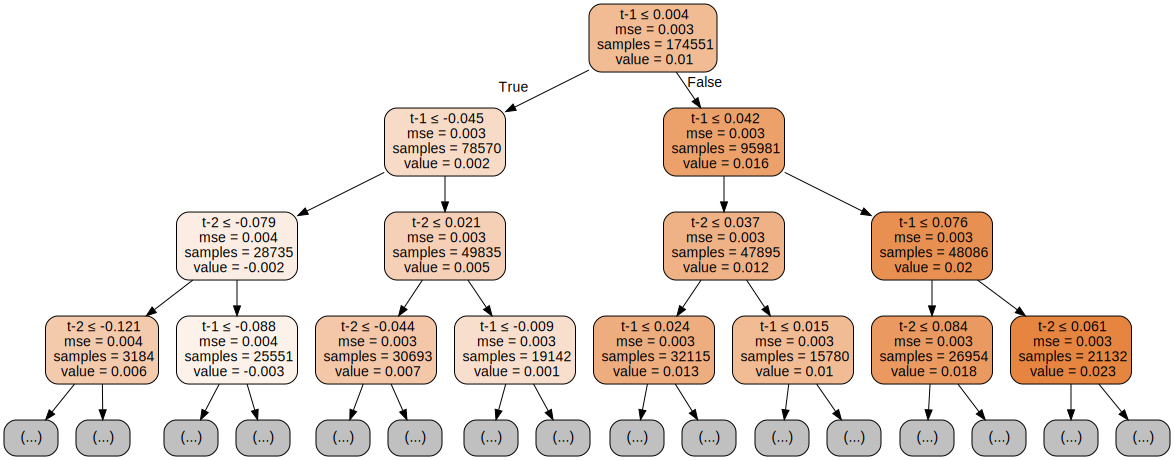

In [10]:
dot_data = export_graphviz(regression_tree,
                           out_file=None,
                           feature_names=X2.columns,
                           max_depth=3,
                           filled=True, 
                           rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph

#### Compare with Linear Regression

##### statsmodels

In [35]:
%%timeit
ols_model = sm.OLS(endog=y_binary, exog=sm.add_constant(X2)).fit()

15.1 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
ols_model = sm.OLS(endog=y, exog=sm.add_constant(X2)).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1904.
Date:                Tue, 25 Sep 2018   Prob (F-statistic):               0.00
Time:                        10:04:31   Log-Likelihood:             2.5857e+05
No. Observations:              174551   AIC:                        -5.171e+05
Df Residuals:                  174548   BIC:                        -5.171e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.000     65.281      0.0

##### Time Series Model

Coefficients slighty different because AR model treats returns as a single time series instead of one for each stock.

In [21]:
%%timeit
sm.tsa.ARMA(endog=, order=(2,0)).fit()

785 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
ar_model = sm.tsa.ARMA(endog=endog, order=(2,0)).fit()
ar_model.params

array([ 0.01001865,  0.15194538, -0.02480083])

In [ ]:
ar_preds = ar_model.predict()

In [50]:
%%timeit
sm.tsa.ARMA(endog=y, order=(2, 2)).fit()

2min 18s ± 244 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
arma_model = sm.tsa.ARMA(endog=y, order=(2, 2)).fit()
print(arma_model.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:               174551
Model:                     ARMA(2, 2)   Log Likelihood              258796.209
Method:                       css-mle   S.D. of innovations              0.055
Date:                Tue, 25 Sep 2018   AIC                        -517580.417
Time:                        09:50:52   BIC                        -517519.997
Sample:                             0   HQIC                       -517562.529
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0099      0.000     58.085      0.000       0.010       0.010
ar.L1.returns     0.6295      0.030     21.000      0.000       0.571       0.688
ar.L2.returns     0.2045      0.017     

In [14]:
arma_preds = arma_model.predict()

In [18]:
preds = X2.assign(arma=arma_preds, ar=ar_preds).sample(frac=.1).sort_values(['t-1', 't-2'])
preds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17455 entries, BPOP to NVDA
Data columns (total 4 columns):
t-1     17455 non-null float64
t-2     17455 non-null float64
arma    17455 non-null float64
ar      17455 non-null float64
dtypes: float64(4)
memory usage: 681.8+ KB


In [24]:
t1, t2, arma, ar = preds.values.T

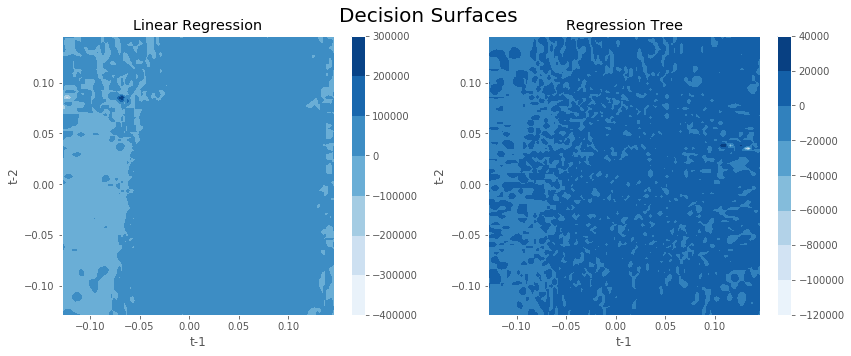

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

t1, t2 = X2.values.T
t1_sim = np.linspace(t1.min(), t1.max(), 100)
t2_sim = np.linspace(t2.min(), t2.max(), 100)
t1_grid, t2_grid = np.meshgrid(t1_sim, t2_sim)

# AR Model
ar_f = interp2d(x=t1, y=t2, z=ar, kind='cubic')
ret1 = ar_f(x=t1_sim, y=t2_sim)
surface1 = axes[0].contourf(t1_grid, t2_grid, ret1, cmap='Blues')
plt.colorbar(mappable=surface1, ax=axes[0])

# ARMA Model
arma_f = interp2d(x=t1, y=t2, z=arma)
ret2= arma_f(x=t1_sim, y=t2_sim)
surface2 = axes[1].contourf(t1_grid, t2_grid, ret2, cmap='Blues')
plt.colorbar(mappable=surface2, ax=axes[1])

# Format plots
titles = ['Linear Regression', 'Regression Tree']
for i, ax in enumerate(axes):
    ax.set_xlabel('t-1')
    ax.set_ylabel('t-2')
    ax.set_title(titles[i])

fig.suptitle('Decision Surfaces', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9);

##### sklearn

In [29]:
lin_reg = LinearRegression()

In [37]:
%%timeit
lin_reg.fit(X=X2,y=y)

8.56 ms ± 80.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
lin_reg.intercept_

0.008849391302235901

In [38]:
lin_reg.coef_

array([ 0.14664542, -0.03727445])

#### Plot Decision Surfaces

In [ ]:
t1, t2 = np.meshgrid(np.linspace(X2['t-1'].min(), X2['t-1'].max(), 1000),
                     np.linspace(X2['t-2'].min(), X2['t-2'].max(), 1000))
X_data = np.c_[t1.ravel(), t2.ravel()]

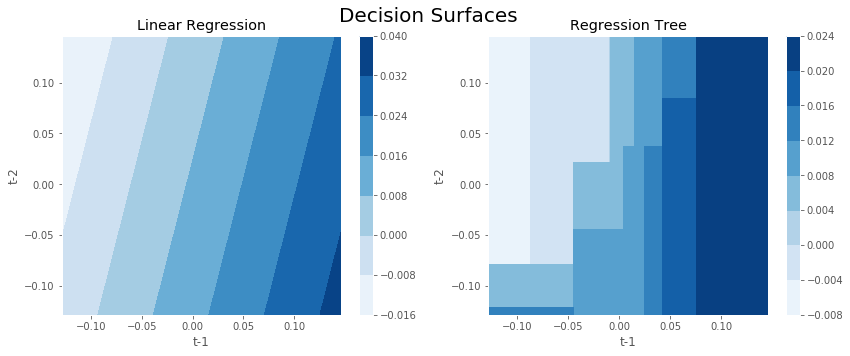

In [52]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# Linear Regression
ret1 = lin_reg.predict(X_data).reshape(t1.shape)
surface1 = axes[0].contourf(t1, t2, ret1, cmap='Blues')
plt.colorbar(mappable=surface1, ax=axes[0])

# Regression Tree
ret2 = regression_tree.predict(X_data).reshape(t1.shape)
surface2 = axes[1].contourf(t1, t2, ret2, cmap='Blues')
plt.colorbar(mappable=surface2, ax=axes[1])

# Format plots
titles = ['Linear Regression', 'Regression Tree']
for i, ax in enumerate(axes):
    ax.set_xlabel('t-1')
    ax.set_ylabel('t-2')
    ax.set_title(titles[i])

fig.suptitle('Decision Surfaces', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9);

### Classifier

#### Configure Tree

In [53]:
classifier = DecisionTreeClassifier(criterion='gini', 
                                    splitter='best', 
                                    max_depth=4, 
                                    min_samples_split=2, 
                                    min_samples_leaf=1, 
                                    min_weight_fraction_leaf=0.0,
                                    max_features=None, 
                                    random_state=42,
                                    max_leaf_nodes=None, 
                                    min_impurity_decrease=0.0, 
                                    min_impurity_split=None, 
                                    class_weight=None, 
                                    presort=False)

#### Train Tree

In [55]:
%%timeit
classifier.fit(X=X2, y=y_binary)

138 ms ± 3.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Visualize Tree

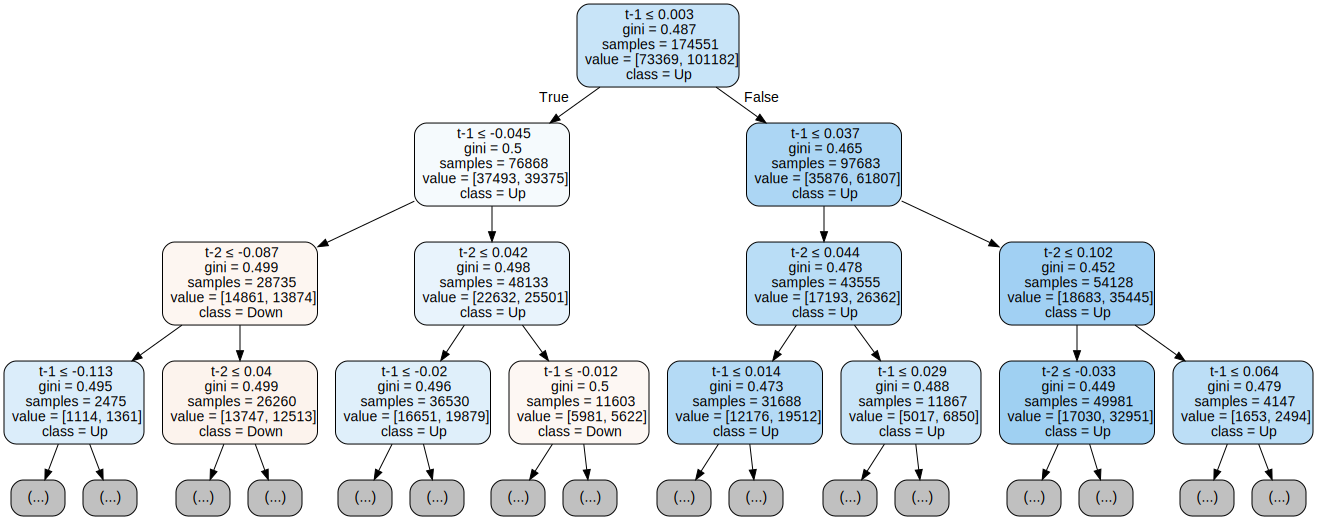

In [57]:
dot_data = export_graphviz(classifier,
                           out_file=None,
                           feature_names=X2.columns,
                           class_names=['Down', 'Up'],
                           max_depth=3,
                           filled=True, 
                           rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph

#### Compare with Logistic Regression

##### Statsmodels

In [63]:
model = sm.Logit(endog=y_binary, exog=sm.add_constant(X2)).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.671948
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                returns   No. Observations:               174551
Model:                          Logit   Df Residuals:                   174548
Method:                           MLE   Df Model:                            2
Date:                Tue, 25 Sep 2018   Pseudo R-squ.:                 0.01242
Time:                        14:50:41   Log-Likelihood:            -1.1729e+05
converged:                       True   LL-Null:                   -1.1876e+05
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2905      0.005     57.954      0.000       0.281       0.300
t-1            4.8250      0.

##### sklearn

In [59]:
logistic_reg = LogisticRegression()

In [60]:
%%timeit
logistic_reg.fit(X=X2, y=y_binary)

140 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [64]:
logistic_reg.coef_

array([[ 4.78476114, -1.07214076]])

#### Plot Decision Surfaces

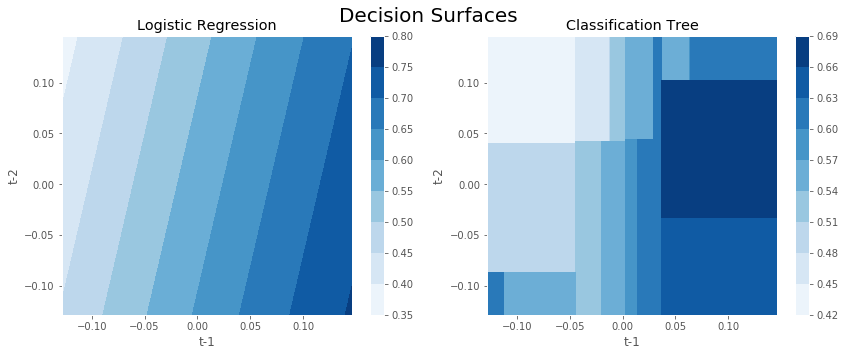

In [65]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# Linear Regression
ret1 = logistic_reg.predict_proba(X_data)[:, 1].reshape(t1.shape)
surface1 = axes[0].contourf(t1, t2, ret1, cmap='Blues')
plt.colorbar(mappable=surface1, ax=axes[0])

# Regression Tree
ret2 = classifier.predict_proba(X_data)[:, 1].reshape(t1.shape)
surface2 = axes[1].contourf(t1, t2, ret2, cmap='Blues')
plt.colorbar(mappable=surface2, ax=axes[1])

# Format plots
titles = ['Logistic Regression', 'Classification Tree']
for i, ax in enumerate(axes):
    ax.set_xlabel('t-1')
    ax.set_ylabel('t-2')
    ax.set_title(titles[i])

fig.suptitle('Decision Surfaces', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9);

### Print Decision Path

Inspired by https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree

In [ ]:
def tree_to_code(tree, feature_names):
    if isinstance(tree, DecisionTreeClassifier):
        model = 'clf'
    elif isinstance(tree, DecisionTreeRegressor):
        model = 'reg'
    else:
        raise ValueError('Need Regression or Classification Tree')
        
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print(indent, f'if {name} <= {threshold:.2%}')
            recurse(tree_.children_left[node], depth + 1)
            print(indent, f'else:  # if {name} > {threshold:.2%}')
            recurse(tree_.children_right[node], depth + 1)
        else:
            pred = tree_.value[node][0]
            val = pred[1]/sum(pred) if model == 'clf' else pred[0]
            print(indent, f'return {val:.2%}')
    recurse(0, 1)

In [ ]:
tree_to_code(classifier, X_simple.columns)

## More Complex Decision Trees with more Features

### Classification Tree

#### Train-Test Split

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

In [68]:
classifier = DecisionTreeClassifier(criterion='gini', 
                                    splitter='best', 
                                    max_depth=3, 
                                    min_samples_split=2, 
                                    min_samples_leaf=1, 
                                    min_weight_fraction_leaf=0.0,
                                    max_features=None, 
                                    random_state=42,
                                    max_leaf_nodes=None, 
                                    min_impurity_decrease=0.0, 
                                    min_impurity_split=None, 
                                    class_weight=None, 
                                    presort=False)

In [69]:
classifier.fit(X=X_train, y=y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

#### Plot Tree

In [70]:
dot_data = export_graphviz(classifier,
                           out_file='classifier.dot',
                           feature_names=X.columns,
                           class_names=['Down', 'Up'],
                           max_depth=4,
                           filled=True, 
                           rounded=True,
                           special_characters=True)


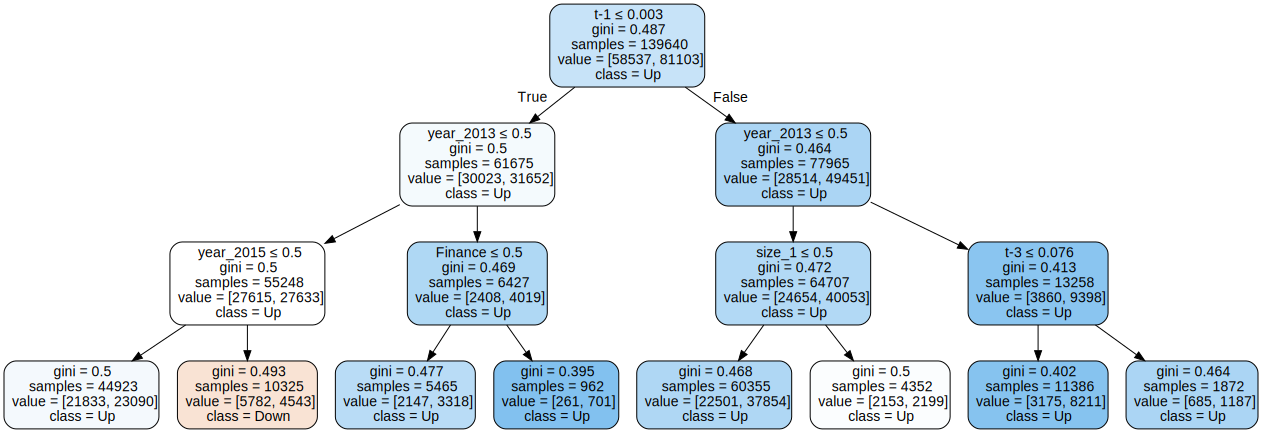

In [71]:
graph = graphviz.Source(Path('classifier.dot').read_text())
graph

#### Evaluate Test Set

In [75]:
y_pred = classifier.predict_proba(X_test)[:, 1]

In [76]:
roc_auc_score(y_true=y_test, y_score=y_pred)

0.5813572459443236

### Regression Tree

#### Train-Test Split

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Configure Tree

In [80]:
regression_tree = DecisionTreeRegressor(criterion='mse',
                                        splitter='best',
                                        max_depth=5,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features=None,
                                        random_state=42,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        presort=False)

#### Train Model

In [81]:
regression_tree.fit(X=X_train, y=y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

#### Visualize Tree

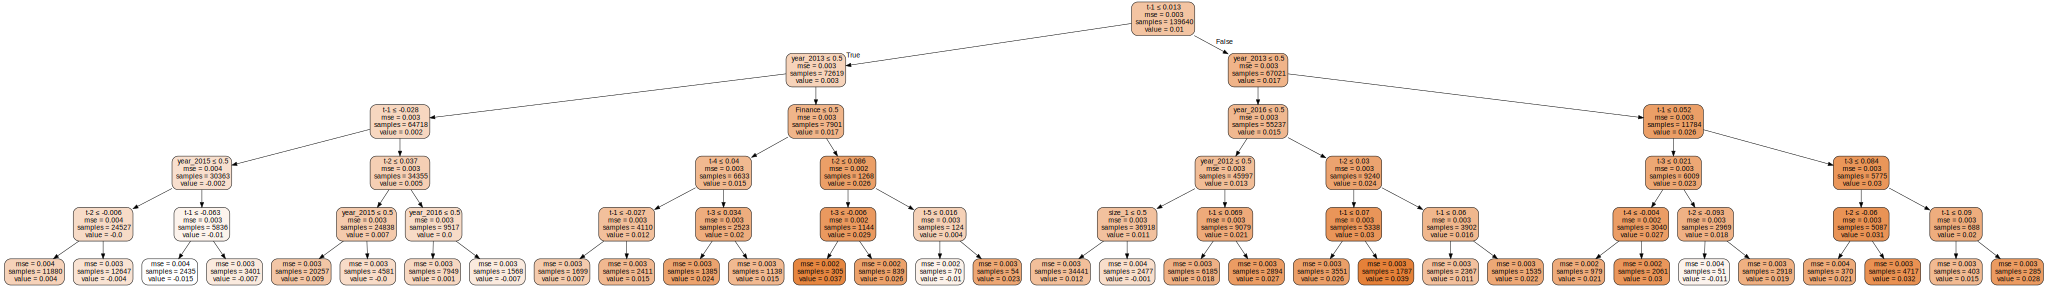

In [83]:
dot_data = export_graphviz(regression_tree,
                           out_file=None,
                           feature_names=X.columns,
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph

#### Evaluate Test Set

In [84]:
y_pred = regression_tree.predict(X_test)

In [85]:
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))

0.05466243298021144

### Parameter Tuning

Cross-validate key parameters

In [125]:
def plot_cv_results(cv_scores, metric='AUC', parameter='Max. Depth'):
    fig, ax = plt.subplots(figsize=(12,6))
    df = pd.DataFrame(cv_scores)
    sns.tsplot(df.values, time=df.columns, ax=ax)
    ax.set_title(f'{len(df)}-Fold Cross-Validation Result')
    ax.set_xlabel(parameter)
    ax.set_ylabel(metric)
    ax.axvline(df.mean().idxmin(), ls='--', c='k', lw=1);

#### Classifier

##### Cross-Validation Score

In [128]:
clf_results = {}
for max_depth in range(1, 26):
    clf_tree = DecisionTreeClassifier(criterion='gini',
                                      max_depth=max_depth,
                                      min_samples_leaf=5,
                                      random_state=42)
    clf_results[max_depth] = cross_val_score(clf_tree,
                                             X=X,
                                             y=y_binary,
                                             scoring='roc_auc',
                                             n_jobs=-1,
                                             cv=10)

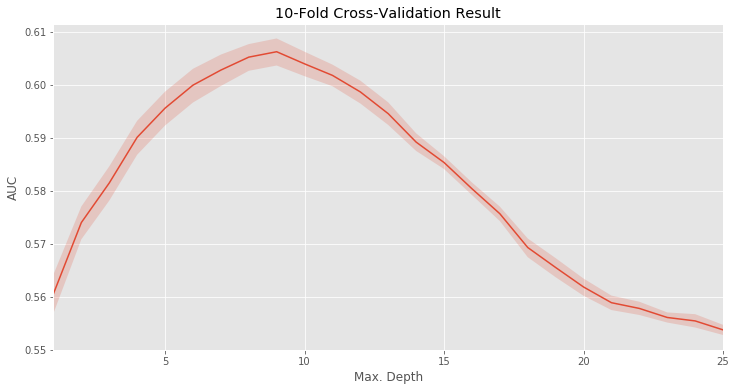

In [129]:
plot_cv_results(clf_results)

##### Train-Test Result

In [214]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
max_depths = range(1, 26)

In [306]:
train_scores, val_scores = {}, {}
for max_depth in max_depths:
    print(max_depth, end=' ', flush=True)
    clf = DecisionTreeClassifier(criterion='gini', 
                                 max_depth=max_depth,
                                 min_samples_leaf=500,
                                 random_state=42)
    train_scores[max_depth], val_scores[max_depth] = [], []
    for train_idx, test_idx in kfold.split(X):
        X_train, y_train,  = X.iloc[train_idx], y_binary.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y_binary.iloc[test_idx]
        clf.fit(X=X_train, y=y_train)

        train_pred = clf.predict_proba(X=X_train)[:, 1]
        train_score = roc_auc_score(y_score=train_pred, y_true=y_train)
        train_scores[max_depth].append(train_score)

        test_pred = clf.predict_proba(X=X_test)[:, 1]
        val_score = roc_auc_score(y_score=test_pred, y_true=y_test)
        val_scores[max_depth].append(val_score)
        
clf_train_scores = pd.DataFrame(train_scores)
clf_valid_scores = pd.DataFrame(val_scores)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

#### Regression Tree

##### Cross-Validation Scores

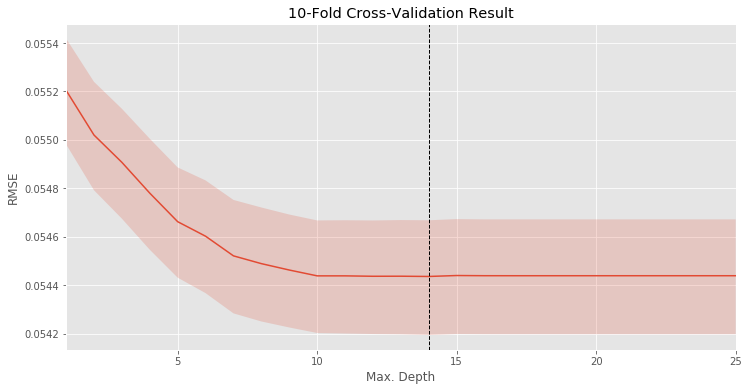

In [311]:
reg_results = {}
for max_depth in range(1, 26):
    reg_tree = DecisionTreeRegressor(criterion='mse',
                                     max_depth=max_depth,
                                     min_samples_leaf=500,
                                     random_state=42)
    reg_results[max_depth] = np.sqrt(-cross_val_score(reg_tree,
                                             X=X,
                                             y=y,
                                             scoring='neg_mean_squared_error',
                                             n_jobs=-1,
                                             cv=10))
    
plot_cv_results(reg_results, metric='RMSE')    

In [312]:
train_scores, val_scores = {}, {}
for max_depth in max_depths:
    print(max_depth, end=' ', flush=True)
    reg_tree = DecisionTreeRegressor(max_depth=max_depth,
                                     min_samples_leaf=500,
                                     random_state=42)
    train_scores[max_depth], val_scores[max_depth] = [], []
    for train_idx, test_idx in kfold.split(X):
        X_train, y_train,  = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        reg_tree.fit(X=X_train, y=y_train)

        train_pred = reg_tree.predict(X=X_train)
        train_score = np.sqrt(mean_squared_error(
            y_pred=train_pred, y_true=y_train))
        train_scores[max_depth].append(train_score)

        test_pred = reg_tree.predict(X=X_test)
        val_score = np.sqrt(mean_squared_error(
            y_pred=test_pred, y_true=y_test))
        val_scores[max_depth].append(val_score)

reg_train_scores = pd.DataFrame(train_scores)
reg_valid_scores = pd.DataFrame(val_scores)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

#### Plot Results

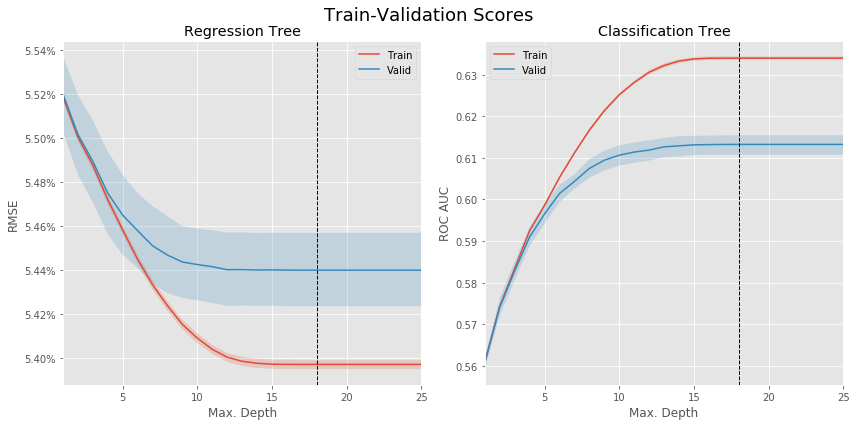

In [314]:
fig, axes = plt.subplots(ncols=2, figsize=(12,6))

sns.tsplot(data=np.dstack((reg_train_scores, reg_valid_scores)), 
           time=pd.Series(max_depths, name='Max. Depth'), 
           condition=['Train', 'Valid'], 
           ci=95, 
           ax=axes[0])
axes[0].set_title('Regression Tree')
axes[0].set_ylabel('RMSE')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
axes[0].axvline(x=clf_valid_scores.mean().idxmax(), ls='--', c='k', lw=1);

sns.tsplot(data=np.dstack((clf_train_scores, clf_valid_scores)), 
           time=pd.Series(max_depths, name='Max. Depth'), 
           condition=['Train', 'Valid'], 
           ci=95, 
           ax=axes[1])
axes[1].set_title('Classification Tree')
axes[1].set_ylabel('ROC AUC')
axes[1].axvline(x=clf_valid_scores.mean().idxmax(), ls='--', c='k', lw=1)

fig.suptitle(f'Train-Validation Scores', fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=.9);

### GridSearch

#### Classification Tree

In [226]:
clf = DecisionTreeClassifier(random_state=42)
param_grid = {'max_depth': range(10, 20),
              'min_samples_leaf': [250, 500, 750],
              'max_features': [None, .8, 'auto']
              }

In [227]:
gridsearch_clf = GridSearchCV(estimator=clf,
                          param_grid=param_grid,
                          scoring='roc_auc',
                          n_jobs=-1,
                          cv=5,
                          refit=True,
                          return_train_score=True)

In [228]:
gridsearch_clf.fit(X=X, y=y_binary)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(15, 20), 'min_samples_leaf': [250, 500, 1000], 'max_features': [None, 0.8, 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [229]:
gridsearch_clf.best_params_

{'max_depth': 16, 'max_features': None, 'min_samples_leaf': 500}

In [230]:
gridsearch_clf.best_score_

0.6114461863571352

#### Regression Tree

In [232]:
reg_tree = DecisionTreeRegressor(random_state=42)

param_grid = {'max_depth': range(5, 20),
              'min_samples_leaf': [250, 500, 750],
              'max_features': [None, .8, 'auto', 'sqrt']
              }

In [233]:
gridsearch_reg = GridSearchCV(estimator=reg_tree,
                              param_grid=param_grid,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1,
                              cv=5,
                              refit=True,
                              return_train_score=True)

In [234]:
gridsearch_reg.fit(X=X, y=y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(5, 20), 'min_samples_leaf': [250, 500, 750], 'max_features': [None, 0.8, 'auto', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [235]:
gridsearch_reg.best_params_

{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 500}

In [236]:
gridsearch_reg.best_score_

-0.002968526952511161

### Learning Curves

#### Classifier

In [ ]:
sizes = np.arange(.1, 1.01, .1)

In [238]:
train_sizes, train_scores, valid_scores = learning_curve(gridsearch_clf.best_estimator_,
                                                          X,
                                                          y_binary,
                                                          train_sizes=sizes,
                                                          cv=5,
                                                          scoring='roc_auc',
                                                          n_jobs=-1,
                                                          shuffle=True,
                                                          random_state=42)
clf_data = np.dstack((train_scores.T, valid_scores.T))

#### Regression Tree

In [239]:
train_sizes, train_scores, valid_scores = learning_curve(gridsearch_reg.best_estimator_,
                                                          X, y,
                                                          train_sizes=sizes,
                                                          cv=5,
                                                          scoring='neg_mean_squared_error',
                                                          n_jobs=-1,
                                                          shuffle=True,
                                                          random_state=42)
reg_data = np.dstack((train_scores.T, valid_scores.T))

#### Plot Result

In [240]:
time = pd.Series(train_sizes, name='Train Size')

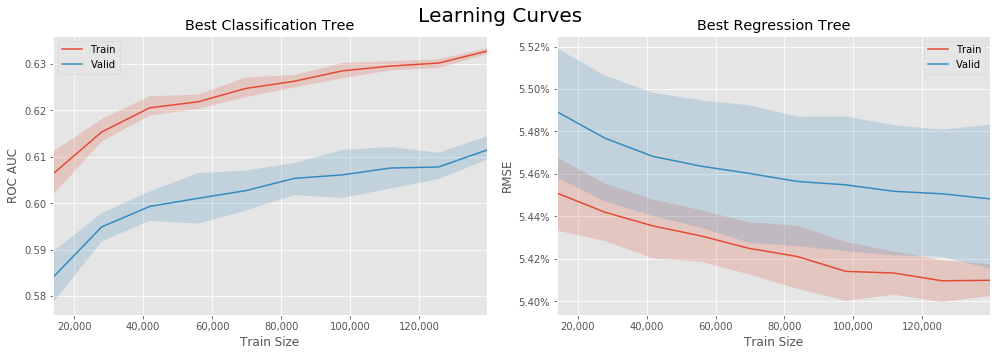

In [260]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
sns.tsplot(data=clf_data, 
           time=time, 
           condition=['Train', 'Valid'], 
           ci=95, 
           ax=axes[0])
axes[0].set_title('Best Classification Tree')
axes[0].set_ylabel('ROC AUC')
axes[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

sns.tsplot(data=np.sqrt(-reg_data), 
           time=time, 
           condition=['Train', 'Valid'], 
           ci=95, 
           ax=axes[1])
axes[1].set_title('Best Regression Tree')
axes[1].set_ylabel('RMSE')
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
fig.suptitle('Learning Curves', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9);

### Feature Importance

In [304]:
top_n = 15
labels = X.columns.str.replace('_', ' ').str.capitalize()
fi_clf = (pd.Series(gridsearch_clf.best_estimator_.feature_importances_, 
                    index=labels).sort_values(ascending=False).iloc[:top_n])
fi_reg = (pd.Series(gridsearch_reg.best_estimator_.feature_importances_, 
                    index=labels).sort_values(ascending=False).iloc[:top_n])

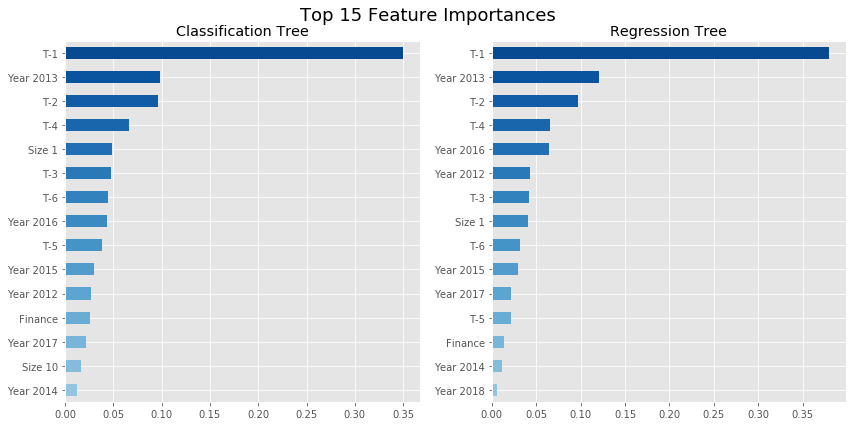

In [305]:
fig, axes= plt.subplots(ncols=2, figsize=(12,6))
color = cm.Blues(np.linspace(.4,.9, top_n))
fi_clf.sort_values().plot.barh(ax=axes[0], title='Classification Tree', color=color)
fi_reg.sort_values().plot.barh(ax=axes[1], title='Regression Tree', color=color)
fig.suptitle(f'Top {top_n} Feature Importances', fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=.9);